This  dataset is from kaggel. I'm using it to predict the next day’s stock market closing price for the company.

* __stock_price_data.txt__ : It contains stock price data wich includes a day’s stock market attributes for the company(like Date, Opnening price, Highest values, Lowest value, Closing Price and Volume).



## Step 1 : Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')
import pickle

Using TensorFlow backend.
/home/akanksha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akanksha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akanksha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akanksha/anaconda3/lib/python3.7/site-packag

## Step 2: Import Data

Import the txt data into dataframe using pandas. 

In [2]:
data = pd.read_csv('stock_price_data.txt')
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [3]:
data.shape

(14058, 7)

As you can see there are around 14058 items, each representing a day’s stock market attributes for the company. Lets see how does it look on a plot :

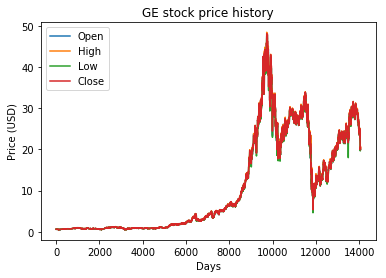

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(data["Open"])
plt.plot(data["High"])
plt.plot(data["Low"])
plt.plot(data["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

It seems the prices — Open, Close, Low, High — don’t vary too much from each other except for occasional slight drops in Low price.
Now let’s check out the plot for volume :

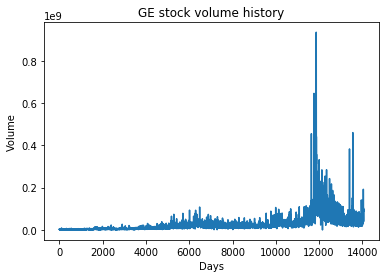

In [5]:
plt.figure()
plt.plot(data["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

There is quite a surge in the number of transactions around 12000th day on the timeline, which happens to coincide with the sudden drop of stock price. May be we can go back to that particular date and dig up old news articles to find what caused it.

## Step 3: Split data into train and test

Transform features by scaling each feature to a given range. When your data is comprised of attributes with varying scales, many machine learning algorithms can benefit from rescaling the attributes to all have the same scale.Often this is referred to as normalization and attributes are often rescaled into the range between 0 and 1

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


In [7]:
df_train.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [8]:
x_train

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       ...,
       [0.56738965, 0.56144866, 0.56900922, 0.56564471, 0.16041384],
       [0.56658613, 0.5678247 , 0.56695173, 0.57270398, 0.24217621],
       [0.57639752, 0.57292971, 0.57755734, 0.57677987, 0.25339457]])

## Step 4: Converting data to time-series and supervised learning problem

Here we are applying LSTM on the training dataset.
LSTM networks are well-suited to classifying, processing and making predictions based on time series data. LSTMs deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.
LSTMs consume input in format [ batch_size, time_steps, Features ]; a 3- dimensional array.
Where,
* __batch_size__ : How many samples of input do you want your Neural Net to see before updating the weights
* __time_steps__ : How many units back in time you want your network to see.
* __Features__ : Number of attributes used to represent each time step, i.e., total number of features used for prediction.


__Time Steps : Here I chose time steps to be 60 which means, I want the network to look back on 60 days of data to predict price on 61th day__

In [9]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print(dim_0)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [10]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

Now using the above functions lets form our train, validation and test datasets

In [11]:
BATCH_SIZE = 30
TIME_STEPS = 60
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

11186
length of time-series i/o (11186, 60, 5) (11186,)
2752
length of time-series i/o (2752, 60, 5) (2752,)


In [12]:
x_t.shape, y_t.shape, x_val.shape, x_test_t.shape, x_temp.shape

((11160, 60, 5), (11160,), (1365, 60, 5), (1365, 60, 5), (2752, 60, 5))

## Step 5 : Create Model : 
We will be using LSTM for this task, which is a variation of Recurrent Neural Network. Creating LSTM model is as simple as this:

In [13]:

lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

Now that you have your model compiled and ready to be trained, train it like shown below.

## Step 6 : Train Model 

In [19]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(("/home/akanksha/Akanksha/Company_Work/Seminar/ML_Problems/Stock Price Prediction/Output.log"), 
                       append=True)

history = lstm_model.fit(x_t, y_t, epochs=10, verbose=1, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])



Train on 11160 samples, validate on 1350 samples
Epoch 1/10
11160/11160 [==============================] - 29s 3ms/step - loss: 0.0168 - val_loss: 0.0519
Epoch 2/10
11160/11160 [==============================] - 29s 3ms/step - loss: 0.0296 - val_loss: 0.0384
Epoch 3/10
11160/11160 [==============================] - 30s 3ms/step - loss: 0.0294 - val_loss: 0.0503
Epoch 4/10
11160/11160 [==============================] - 28s 2ms/step - loss: 0.0340 - val_loss: 0.0476
Epoch 5/10
11160/11160 [==============================] - 32s 3ms/step - loss: 0.0222 - val_loss: 0.0645
Epoch 6/10
11160/11160 [==============================] - 33s 3ms/step - loss: 0.0250 - val_loss: 0.0480
Epoch 7/10
11160/11160 [==============================] - 33s 3ms/step - loss: 0.0147 - val_loss: 0.0650
Epoch 8/10
11160/11160 [==============================] - 32s 3ms/step - loss: 0.0190 - val_loss: 0.0382
Epoch 9/10
11160/11160 [==============================] - 31s 3ms/step - loss: 0.0097 - val_loss: 0.0358
Epoch 

In [20]:
score = lstm_model.evaluate(trim_dataset(x_test_t, BATCH_SIZE),
                    trim_dataset(y_test_t, BATCH_SIZE), verbose=1, batch_size=BATCH_SIZE)

print(score)

1350/1350 [==============================] - 1s 784us/step
0.009226640603446867


dict_keys(['val_loss', 'loss'])


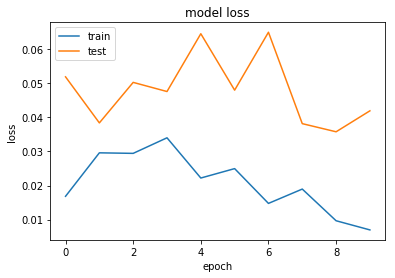

In [21]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
lstm_model.save('lstm_model.h5')

In [33]:
# from keras.models import load_model
model = load_model('lstm_model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (30, 100)                 42400     
_________________________________________________________________
dropout_1 (Dropout)          (30, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (30, 20)                  2020      
_________________________________________________________________
dense_2 (Dense)              (30, 1)                   21        
Total params: 44,441
Trainable params: 44,441
Non-trainable params: 0
_________________________________________________________________
